In [69]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [11]:
import detect_and_track as dt

In [62]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()
## This is for progress bars only ... not sure what `%%capture` does.

In [42]:
from scipy.ndimage import label, generate_binary_structure
def alt_get_labels3d_np(da, crit):
    """Label events through time. (numpy array)"""
    mask = np.where(da >= crit, 1, 0)
    assert len(mask.shape) == 3  # has to be time,lat,lon
    structure_matrix = np.array([[[False,  False, False],
        [ False,  True,  False],
        [False,  False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  False, False],
        [ False,  True,  False],
        [False,  False, False]]])
    la, nf = label(mask, structure=structure_matrix)
    # nf is just an integer
    return la, nf

In [112]:
def event_updater(arr, transformer_dict):
    """Updates labels to new values."""
    if isinstance(arr, xr.DataArray):
        lll = arr.values
    else:
        lll = arr
    new_labels = lll.copy()
    for k in transformer_dict:
        new_labels = np.where(new_labels==k, transformer_dict[k], new_labels)
    if isinstance(arr, xr.DataArray):
        new_labels = xr.DataArray(new_labels, dims=arr.dims, coords=arr.coords)
    return new_labels


def stitchLabels(labels):
    """Temporal concatenation of overlapping events."""
    # 
    # rules:
    # start from time=0 and march forward
    # for each new time:
    # - if an event does not overlap in space with a labeled event in time-1, it is given the next available label
    # - if an event overlaps one previous event, it inherits that label
    # - if an event overlaps more than one previous event, it inherits the smallest of the labels
    # This allows splitting of events
    print(f"SHAPE: {labels.shape} => {labels.shape[0]}")
    output = labels.copy()
    # initialize the labels:
    last_id = np.max(labels[0,:,:])
    for i in range(1,labels.shape[0]):
        slice1 = labels[i,:,:]
        nlbls = np.max(slice1)
        print(f"Time: {i}, number of labels: {nlbls}")
        if nlbls == 0:
            continue # no labels to deal with
        slice0 = labels[i-1,:,:]
        transformer = {}  # dict: keys are the "current label" and values are the "correct" label
        # every event gets an entry in transformer
        for b in range(1,nlbls+1):
            previous_labels = np.where(slice1 == b, slice0, np.nan)
            ppl = np.unique(previous_labels[~np.isnan(previous_labels)])
            ppl = ppl[ppl!=0] # don't include non-events
            print(f"b = {b}, ppl = {ppl}")
            if len(ppl) == 0:
                # indicates no overlap
                last_id += 1 
                transformer[b] = last_id
            elif len(ppl) == 1:
                # overlaps a single event, so continue that event
                transformer[b] = int(ppl[0])
            else:
                # continue the "oldest" event
                transformer[b] = int(np.min(ppl))
        # update:
        output[i,:,:] = event_updater(slice1, transformer)
    return output
        

SHAPE: (5, 10, 10) => 5
Time: 1, number of labels: 1
b = 1, ppl = [1.]
Time: 2, number of labels: 1
b = 1, ppl = [1.]
Time: 3, number of labels: 1
b = 1, ppl = [1.]
Time: 4, number of labels: 0


Text(0.5, 0.98, 'MERGE')

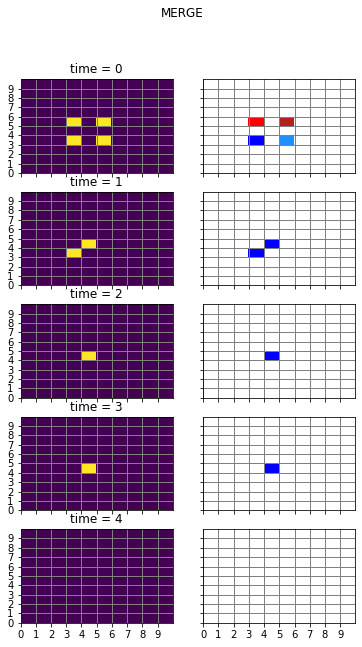

In [113]:
example01 = np.zeros((5,10,10))  # time, x, y
example01[0, [3,5], [3,5]] = 1
example01[0, 3, 5] = 1
example01[0, 5, 3] = 1
example01[1, [3,4], [3,4]] = 1
example01[[2,3], [4], [4]] = 1

labs, numb = dt.get_labels_np(example01, 1)
labs = stitchLabels(labs)

# create discrete colormap
cmap = colors.ListedColormap(['white', 'blue', 'dodgerblue', 'red', 'firebrick'])
bounds = [0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(6,10),nrows=5, ncols=2, sharey=True, sharex=True)
for i in range(5):
    ax[i,0].pcolormesh(example01[i,:,:])
    ax[i,1].pcolormesh(labs[i,:,:], cmap=cmap, norm=norm)
    ax[i,0].set_title(f"time = {i}")
    
[a.grid(which='major', axis='both', linestyle='-', color='gray', linewidth=1) for a in ax.ravel()]
[a.set_xticks(np.arange(0, 10, 1)) for a in ax.ravel() ]
[a.set_yticks(np.arange(0, 10, 1)) for a in ax.ravel()];
fig.suptitle("MERGE")

In [114]:
print(labs)

[[[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 2 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 3 0 4 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0

SHAPE: (5, 10, 10) => 5
Time: 1, number of labels: 1
b = 1, ppl = [1.]
Time: 2, number of labels: 2
b = 1, ppl = [1.]
b = 2, ppl = [1.]
Time: 3, number of labels: 2
b = 1, ppl = [1.]
b = 2, ppl = [2.]
Time: 4, number of labels: 1
b = 1, ppl = [2.]


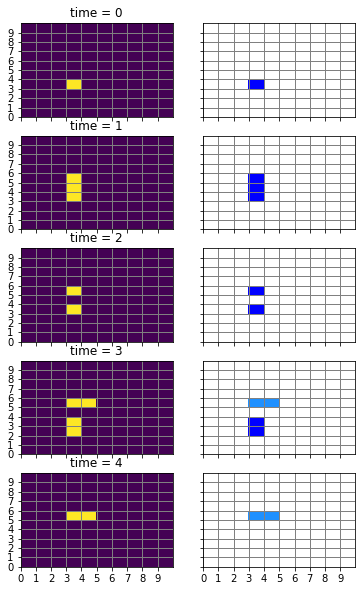

In [115]:
example02 = np.zeros((5,10,10))  # time, x, y
example02[0, 3, 3] = 1
example02[1, [3,4,5], 3] = 1
example02[2, [3,5], 3] = 1
example02[3, [2,3], 3] = 1
example02[3:, 5, [3,4]] = 1

labs, numb = dt.get_labels_np(example02, 1)
labs = stitchLabels(labs)


# create discrete colormap
cmap = colors.ListedColormap(['white', 'blue', 'dodgerblue', 'red', 'firebrick'])
bounds = [0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(6,10),nrows=5, ncols=2, sharey=True, sharex=True)
for i in range(5):
    ax[i,0].pcolormesh(example02[i,:,:])
    ax[i,1].pcolormesh(labs[i,:,:], cmap=cmap, norm=norm)
    ax[i,0].set_title(f"time = {i}")
    
[a.grid(which='major', axis='both', linestyle='-', color='gray', linewidth=1) for a in ax.ravel()]
[a.set_xticks(np.arange(0, 10, 1)) for a in ax.ravel() ]
[a.set_yticks(np.arange(0, 10, 1)) for a in ax.ravel()];



In [116]:
labs

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [36]:
generate_binary_structure(3, 2)

array([[[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])

In [38]:
np.array([[[False,  False, False],
        [ False,  True,  False],
        [False,  False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])

array([[[False, False, False],
        [False,  True, False],
        [False, False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])

In [50]:
for i in range(1, 10):
    print(i)

1
2
3
4
5
6
7
8
9


In [98]:
A = np.array([np.nan, 3, np.nan, 0, np.nan, 3, 0, 0, 1])
B = np.unique(A[~np.isnan(A)])

In [103]:
np.unique(A[~np.isnan(A)])

array([0., 1., 3.])

In [63]:
def proc_np(arr):
    arr *= 2

In [109]:
A = np.array([0, 1, 4])
A = A[A!=0]
print(A)

[1 4]


In [104]:
np.intersect1d(np.nonzero(A), ~np.isnan(A))

array([0, 1])

In [107]:
A != 0

array([ True,  True,  True, False,  True,  True, False, False,  True])